In [1]:
import pickle
import copy
import numpy as np
import g2o
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append("..")
from mapper.geometry import from_twist, to_twist

np.random.seed(0)

In [2]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
pose_graph = pickle.load(open("pose_graph.pkl", "rb"))
map_points = pickle.load(open("map_points.pkl", "rb"))

In [3]:
print(Counter(sorted([len([v for v in ob.values() if v is not None]) for ob in map_points.observations])))
print(Counter(sorted([len(ob) for ob in map_points.observations])))

Counter({2: 1533, 3: 681, 4: 424, 5: 260, 6: 86, 7: 14})
Counter({3: 646, 2: 642, 4: 597, 5: 551, 6: 451, 7: 110, 9: 1})


In [4]:
map_points_bak = np.copy(map_points.pts_3d)
print(map_points_bak)

[[ 0.5544012  -0.64260791 11.98360061]
 [ 0.87429767 -2.72028489 15.60273631]
 [ 1.4773444  -0.55696087 11.7489116 ]
 ...
 [-8.28509113  0.40099662 10.77853298]
 [-5.96945378  1.05715315 10.834062  ]
 [-8.26513326  1.29556488 10.90147264]]


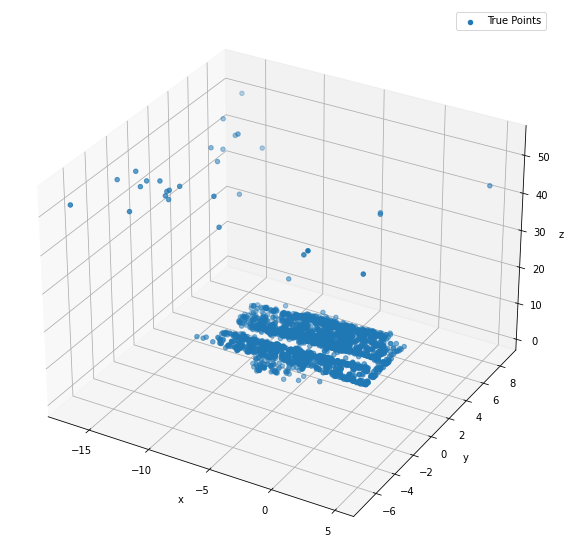

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points.pts_3d[:, 0], map_points.pts_3d[:, 1], map_points.pts_3d[:, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["True Points", "Before Optimization", "After Optimization"])
plt.show()

In [6]:
###################################################################
#
# local bundle adjustment
#
###################################################################

newest_node_id = list(sorted(pose_graph.nodes))[-1]
print("Bundle adjustment for keyframe {}".format(newest_node_id))

# get node_ids of neighboring keyframes
neighbors_keyframes = [node_id for _, node_id in sorted(
    pose_graph.edges(newest_node_id))]
print("Neighboring keyframes: {}".format(neighbors_keyframes))
nodes = [*neighbors_keyframes, newest_node_id]

## setup optimizer and camera parameters
robust_kernel = True
optimizer = g2o.SparseOptimizer()
solver = g2o.BlockSolverSE3(g2o.LinearSolverCholmodSE3())
solver = g2o.OptimizationAlgorithmLevenberg(solver)
optimizer.set_algorithm(solver)

focal_length = (camera_matrix[0,0] + camera_matrix[1,1]) / 2
principal_point = (camera_matrix[0,2], camera_matrix[1,2])
print("focal_length: ", focal_length, "principal_point: ", principal_point)
cam = g2o.CameraParameters(focal_length, principal_point, 0)
cam.set_id(0)
optimizer.add_parameter(cam)

Bundle adjustment for keyframe 8
Neighboring keyframes: [3, 4, 5, 6, 7]
focal_length:  1121.8716561940905 principal_point:  (321.2278456933972, 265.04827021019815)


True

In [7]:
for node_id in nodes:
    print(node_id)
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    print(R, t)

3
[[ 9.99791215e-01 -1.87176649e-03  2.03475330e-02]
 [ 5.23737968e-04  9.97815868e-01  6.60546754e-02]
 [-2.04267302e-02 -6.60302274e-02  9.97608519e-01]] [[-2.86086489]
 [ 0.1890882 ]
 [-1.54294852]]
4
[[ 0.99992826 -0.00558123  0.01059788]
 [ 0.00498569  0.99845109  0.05541268]
 [-0.01089074 -0.05535586  0.99840729]] [[-3.83709026]
 [-0.02691386]
 [-1.51718972]]
5
[[ 0.99981846 -0.00759482  0.01747453]
 [ 0.00697772  0.99935915  0.03510829]
 [-0.01772998 -0.03497998  0.99923073]] [[-5.02590853]
 [-0.06522075]
 [-1.36689774]]
6
[[ 0.99989445 -0.00699994  0.01273112]
 [ 0.00672159  0.99974027  0.02177663]
 [-0.01288025 -0.02168876  0.9996818 ]] [[-6.05554201]
 [-0.06135958]
 [-1.29879514]]
7
[[ 0.99991333 -0.00895577 -0.00965067]
 [ 0.00907848  0.99987754  0.0127473 ]
 [ 0.00953532 -0.0128338   0.99987218]] [[-6.84096471]
 [-0.06398643]
 [-1.33473061]]
8
[[ 0.99986363 -0.00940236 -0.01357664]
 [ 0.00954444  0.99989997  0.01043853]
 [ 0.01347713 -0.01056669  0.99985335]] [[-7.87657641]

In [8]:
# add current keyframe poses
true_poses = []
for i, node_id in enumerate(nodes):
    print("Using keyframe {} for local BA".format(node_id))
    R, t = from_twist(pose_graph.nodes[node_id]["pose"])
    pose = g2o.SE3Quat(R, np.squeeze(t))
    true_poses.append(pose)

    v_se3 = g2o.VertexSE3Expmap()
    v_se3.set_id(node_id)
    v_se3.set_estimate(pose)
    #if node_id < 2:
    #    v_se3.set_fixed(True)
    optimizer.add_vertex(v_se3)

# add map points
point_id = len(pose_graph)
inliers = dict()
for i, (point, observation) in enumerate(zip(map_points.pts_3d, map_points.observations)):
    
    # skip points not visible in the selected subset of key frames
    if not any([node_id in nodes for node_id in observation.keys()]):
        continue

    vp = g2o.VertexSBAPointXYZ()
    vp.set_id(point_id)
    vp.set_marginalized(True)
    vp.set_estimate(point)
    optimizer.add_vertex(vp)

 
    for node_id, kp_idx in observation.items():
        if node_id not in nodes:
            continue
        if kp_idx is None:
            continue
        kp = pose_graph.nodes[node_id]["kp"]
        #print("kp[kp_idx]", kp[kp_idx], kp[kp_idx].shape, kp[kp_idx].dtype, kp_idx, node_id)
        measurement = kp[kp_idx]
        #print(i, point_id, node_id, measurement)
        
        edge = g2o.EdgeProjectXYZ2UV()
        edge.set_vertex(0, vp)  # map point
        edge.set_vertex(1, optimizer.vertex(node_id))  # pose of observing keyframe
        edge.set_measurement(measurement)   # needs to be set to the keypoint pixel position corresponding to that map point in that key frame (pose)
        edge.set_information(np.identity(2))
        if robust_kernel:
            edge.set_robust_kernel(g2o.RobustKernelHuber())
            #edge.set_robust_kernel(g2o.RobustKernelHuber(np.sqrt(5.991)))  # 95% CI

        edge.set_parameter_id(0, 0)
        optimizer.add_edge(edge)

    inliers[point_id] = i
    point_id += 1

print('num vertices:', len(optimizer.vertices()))
print('num edges:', len(optimizer.edges()))

Using keyframe 3 for local BA
Using keyframe 4 for local BA
Using keyframe 5 for local BA
Using keyframe 6 for local BA
Using keyframe 7 for local BA
Using keyframe 8 for local BA
num vertices: 2529
num edges: 6257


In [9]:
print('Performing full BA:')
optimizer.initialize_optimization()
optimizer.set_verbose(True)
optimizer.optimize(10)

poses_optimized = []
map_points_optimized = np.copy(map_points.pts_3d)

# read out optimized poses
for node_id in nodes:
    print(node_id)
    vp = optimizer.vertex(node_id)
    se3quat = vp.estimate()
    R = np.copy(se3quat.to_homogeneous_matrix()[0:3, 0:3])
    t = np.copy(se3quat.to_homogeneous_matrix()[0:3, 3])
    print(R, t)
    poses_optimized.append(to_twist(R, t))

# read out optimized map points
for point_id, i in inliers.items():
    vp = optimizer.vertex(point_id)
    map_points_optimized[i, :] = np.copy(vp.estimate())    

Performing full BA:
3
[[ 0.88308174  0.03654487  0.46779388]
 [ 0.02283371  0.99243427 -0.12063519]
 [-0.46866328  0.11721221  0.87556612]] [-3.17418103  0.39798862  0.03292014]
4
[[ 0.80423321  0.03816142  0.59308739]
 [ 0.00605838  0.99735808 -0.07238891]
 [-0.59428297  0.06181071  0.80187729]] [-3.89574319  0.15213036  1.03055902]
5
[[ 0.71784899  0.05264606  0.69420546]
 [-0.01952271  0.99826684 -0.05551737]
 [-0.69592506  0.02630031  0.71763263]] [-4.4993829   0.19091864  2.4318794 ]
6
[[ 0.99400061  0.05401271  0.09510737]
 [-0.052344    0.99842971 -0.01995556]
 [-0.09603588  0.01485754  0.99526698]] [-5.20752447  0.28298302 -1.25817842]
7
[[ 0.99610917  0.02088679  0.085617  ]
 [-0.02381291  0.9991617   0.03329919]
 [-0.08484972 -0.03520842  0.99577151]] [-6.02038441  0.08304435 -1.20954896]
8
[[ 0.99962809  0.0244164  -0.01214546]
 [-0.02363456  0.9978693   0.06081336]
 [ 0.01360443 -0.0605037   0.99807526]] [-7.38791421  0.09866301 -1.55797424]


In [10]:
np.linalg.norm(map_points_optimized - map_points_bak, axis=0)

array([0.17649363, 0.35217568, 3.61345109])

In [11]:
map_points_optimized, map_points_bak

(array([[ 0.5544012 , -0.64260791, 11.98360061],
        [ 0.87429767, -2.72028489, 15.60273631],
        [ 1.4773444 , -0.55696087, 11.7489116 ],
        ...,
        [-8.28368603,  0.40072632, 10.78085468],
        [-5.96804452,  1.05689525, 10.83604915],
        [-8.26374007,  1.29527653, 10.90376996]]),
 array([[ 0.5544012 , -0.64260791, 11.98360061],
        [ 0.87429767, -2.72028489, 15.60273631],
        [ 1.4773444 , -0.55696087, 11.7489116 ],
        ...,
        [-8.28509113,  0.40099662, 10.77853298],
        [-5.96945378,  1.05715315, 10.834062  ],
        [-8.26513326,  1.29556488, 10.90147264]]))

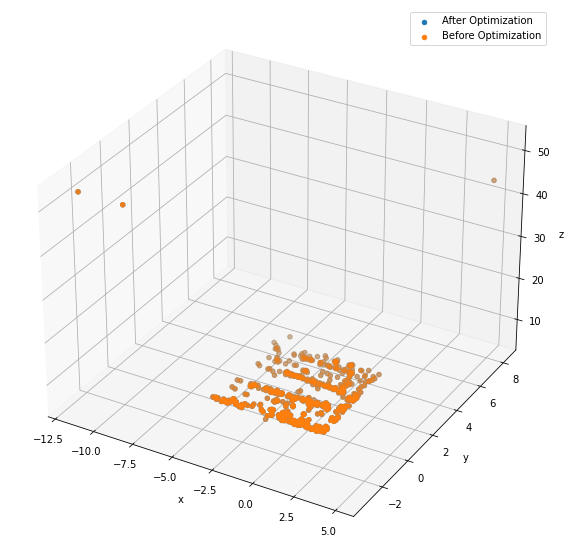

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_points_optimized[:500, 0], map_points_optimized[:500, 1], map_points_optimized[:500, 2])
ax.scatter(map_points_bak[:500, 0], map_points_bak[:500, 1], map_points_bak[:500, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.legend(["After Optimization", "Before Optimization", ])
plt.show()

### Local BA with automatic determination of visibility of map points

Map points are prjected in each keyframe based on the keyframe pose and visibility of the map point in the respective keyframe is determined.

PROBLEM: We do not have the corresponding keypoint pixel coordinates in all frames. Solution: Perform data association in odometry and build a covisibility graph.